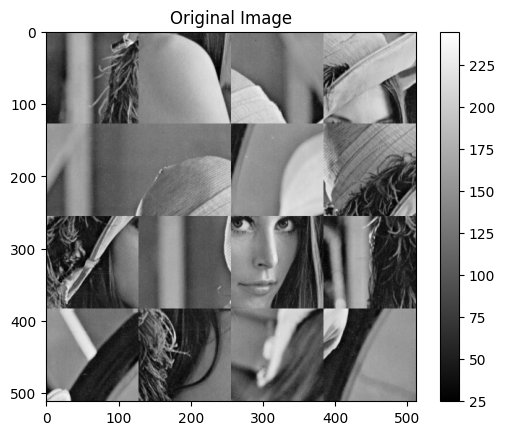

Iterations: 1379
Time: 5.49 seconds
Memory: 193.28 MB


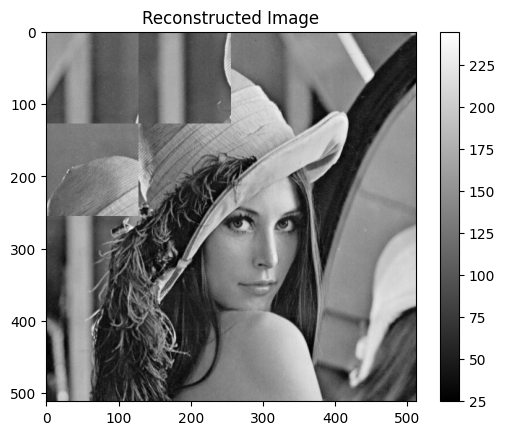

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import math
import copy
from collections import deque
import time
import psutil


# Data Loading - Load a 512x512 matrix from an Octave .mat text file
def load_octave_column_matrix(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    matrix_data = []
    for line in lines[5:]: 
        line = line.strip()
        if line:
            try:
                matrix_data.append(int(line))
            except ValueError:
                continue

    matrix = np.array(matrix_data)
    if matrix.size != 512 * 512:
        raise ValueError(f"Expected 262144 elements, got {matrix.size}")

    return matrix.reshape((512, 512))

# Image Patching and Reconstruction
# Divide a 512x512 image into 16 patches of 128x128 each
def create_patches(image, patch_size=128):
    patches = {}
    grid_indices = []
    z = 0
    num_patches = image.shape[0] // patch_size

    for i in range(num_patches):
        row = []
        for j in range(num_patches):
            row.append(z)
            patch = image[
                i * patch_size:(i + 1) * patch_size,
                j * patch_size:(j + 1) * patch_size
            ]
            patches[z] = patch
            z += 1
        grid_indices.append(row)

    return patches, grid_indices

#  Rebuild a full image from 128x128 patches using the grid layout.
def reconstruct_image(patches, grid):
    patch_height, patch_width = patches[0].shape
    grid_height, grid_width = len(grid), len(grid[0])

    full_img = np.zeros(
        (grid_height * patch_height, grid_width * patch_width), dtype=np.uint8
    )

    for i, row in enumerate(grid):
        for j, patch_idx in enumerate(row):
            full_img[
                i * patch_height:(i + 1) * patch_height,
                j * patch_width:(j + 1) * patch_width
            ] = patches[patch_idx]

    return full_img


# Find the best-matching patch for a given direction.
def find_best_match(available, parent_patch, all_patches, direction):
    best_score = float("inf")
    best_patch = -1
    parent = np.array(parent_patch)

    for idx in available:
        child = np.array(all_patches[idx])
        score = 0

        if direction == (0, 1):   # Right
            score = np.sum(np.abs(parent[:, -1] - child[:, 0]))
        elif direction == (0, -1):  # Left
            score = np.sum(np.abs(parent[:, 0] - child[:, -1]))
        elif direction == (1, 0):   # Down
            score = np.sum(np.abs(parent[-1, :] - child[0, :]))
        elif direction == (-1, 0):  # Up
            score = np.sum(np.abs(parent[0, :] - child[-1, :]))

        if score < best_score:
            best_score = score
            best_patch = idx

    return best_patch


# Fill a 4x4 grid using BFS based on patch edge similarity
def bfs_fill(grid, patches, available_indices):
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    queue = deque([(0, 0)])
    visited = {(0, 0)}

    while queue:
        x, y = queue.popleft()

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < 4 and 0 <= ny < 4 and (nx, ny) not in visited:
                queue.append((nx, ny))
                visited.add((nx, ny))
                best_match = find_best_match(available_indices, patches[grid[x][y]], patches, (dx, dy))
                grid[nx][ny] = best_match
                available_indices.remove(best_match)


# Compute edge gradients using Sobel filters and return gradient magnitude
def calculate_gradients(image, threshold=100):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)

    grad_x[magnitude < threshold] = 0
    grad_y[magnitude < threshold] = 0
    grad_sum = np.sqrt(np.sum(np.abs(grad_x)) + np.sum(np.abs(grad_y)))
    return grad_sum


# Return valid 4-neighbors of a grid cell
def get_neighbors(i, j, grid):
    rows, cols = len(grid), len(grid[0])
    neighbors = []
    if i > 0: neighbors.append((i - 1, j))
    if i < rows - 1: neighbors.append((i + 1, j))
    if j > 0: neighbors.append((i, j - 1))
    if j < cols - 1: neighbors.append((i, j + 1))
    return neighbors

# Compute total mismatch score between neighboring patches
def value_function(grid, patches):
    score = 0
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            for ni, nj in get_neighbors(i, j, grid):
                patch_a = patches[grid[i][j]]
                patch_b = patches[grid[ni][nj]]

                if nj == j + 1:  # right
                    score += np.sum(np.abs(patch_a[:, -1] - patch_b[:, 0]))
                elif nj == j - 1:  # left
                    score += np.sum(np.abs(patch_b[:, -1] - patch_a[:, 0]))
                elif ni == i + 1:  # down
                    score += np.sum(np.abs(patch_a[-1, :] - patch_b[0, :]))
                elif ni == i - 1:  # up
                    score += np.sum(np.abs(patch_b[-1, :] - patch_a[0, :]))

    return np.sqrt(score)



# Optimize grid arrangement using Simulated Annealing
def simulated_annealing(grid, patches, init_score):
    current_grid = copy.deepcopy(grid)
    best_grid = copy.deepcopy(grid)
    current_score = init_score
    best_score = init_score

    temp = 1000
    alpha = 0.995
    final_temp = 1
    iterations = 0

    while temp > final_temp:
        iterations += 1

        # Swap two random patches
        x1, y1 = random.randint(0, 3), random.randint(0, 3)
        x2, y2 = random.randint(0, 3), random.randint(0, 3)
        current_grid[x1][y1], current_grid[x2][y2] = current_grid[x2][y2], current_grid[x1][y1]

        new_score = value_function(current_grid, patches)
        accept = (new_score < current_score) or (random.random() < math.exp((current_score - new_score) / temp))

        if accept:
            current_score = new_score
            if current_score < best_score:
                best_score = current_score
                best_grid = copy.deepcopy(current_grid)
        else:
            current_grid[x1][y1], current_grid[x2][y2] = current_grid[x2][y2], current_grid[x1][y1]

        temp *= alpha

    return best_grid, best_score, iterations




#  Visualization
def show_image(image, title="Reconstructed Image"):
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.colorbar()
    plt.show()
    
    


image_data = load_octave_column_matrix("jigsaw.mat")
image_data = image_data.T
# Show the original image before any processing
show_image(image_data, title="Original Image")

patches, state_mat = create_patches(image_data)

final_grid = None
final_score = float("inf")
iterations = 0

start_time = time.time()

for i in range(16):
    grid = [[-1 for _ in range(4)] for _ in range(4)]
    grid[0][0] = i
    remaining = list(range(16))
    remaining.remove(i)

    bfs_fill(grid, patches, remaining)
    new_img = reconstruct_image(patches, grid)
    score = calculate_gradients(new_img)

    candidate_grid, candidate_score, iter_count = simulated_annealing(grid, patches, score)

    if candidate_score < final_score:
        final_score = candidate_score
        final_grid = candidate_grid
        iterations = iter_count

process = psutil.Process()
total_time = time.time() - start_time
memory_usage = process.memory_info().rss / (1024 * 1024)

print(f"Iterations: {iterations}")
print(f"Time: {total_time:.2f} seconds")
print(f"Memory: {memory_usage:.2f} MB")

best_img = reconstruct_image(patches, final_grid)
show_image(best_img)


In [12]:
from scipy.io import savemat

savemat('final.mat', {'best_img': best_img})